In [45]:
from datetime import datetime
import psycopg2
import numpy as np



In [12]:
def table_format(cur, rows):    
    # Format and print the table
    column_names = [desc[0] for desc in cur.description]  # Get the column names
    table_data = [column_names] + list(rows)  # Combine column names with row data

    # Calculate the maximum width for each column
    column_widths = [max(len(str(row[i])) for row in table_data) for i in range(len(column_names))]

    # Format and print the table headers
    header_format = "|".join(["{{:<{}}}".format(width) for width in column_widths])
    header = header_format.format(*column_names)
    print(header)
    print("-" * len(header))

    # Format and print the table rows
    row_format = "|".join(["{{:<{}}}".format(width) for width in column_widths])
    for row in table_data[1:]:
        formatted_row = []
        for i, value in enumerate(row):
            if isinstance(value, datetime):
                formatted_row.append(value.strftime("%Y-%m-%d %H:%M:%S"))  # Customize the datetime format as desired
            else:
                formatted_row.append(str(value))
        formatted_row = row_format.format(*formatted_row)
        print(formatted_row)


In [16]:
# Connect to the Postgres container using the container name as the hostname
conn = psycopg2.connect(
    dbname="accident_analysis",
    user="postgres",
    password="password",
    host="localhost",
    port="5433"
)

# Create a cursor and execute a query
cur = conn.cursor()
cur.execute("SELECT * FROM accidents LIMIT 5")

# Fetch all rows from the result set
rows = cur.fetchall()
table_format(cur, rows)

# Close the cursor and the connection
cur.close()
conn.close()

report_id|date_time          |violation_section|violation_type|injured|killed|hit_run_lvl
-----------------------------------------------------------------------------------------
171111   |2015-01-14 20:00:00|MISC-HAZ         |VC            |0      |0     |MISDEMEANOR
192016   |2015-03-19 12:00:00|MISC-HAZ         |VC            |0      |0     |MISDEMEANOR
190012   |2015-03-24 03:05:00|22107            |VC            |2      |0     |           
191866   |2015-03-27 23:56:00|22107            |VC            |1      |0     |           
185207   |2015-07-06 11:45:00|20002(A)         |VC            |0      |0     |MISDEMEANOR


1/ Determine the top 2 ranking of each vehicle make based on the total number of accidents for each month

In [28]:
# Connect to the Postgres container using the container name as the hostname
conn = psycopg2.connect(
    dbname="accident_analysis",
    user="postgres",
    password="password",
    host="localhost",
    port="5433"
)

# Create a cursor and execute a query
cur = conn.cursor()
cur.execute("""
SELECT date_trunc('month', date_time) AS month,
       violation_type,
       AVG(injured) OVER (PARTITION BY date_trunc('month', date_time), violation_type) AS average_injured_per_day
FROM accidents;
""")

# Fetch all rows from the result set
rows = cur.fetchall()
table_format(cur, rows)

# Close the cursor and the connection
cur.close()
conn.close()

month              |violation_type|average_injured_per_day
----------------------------------------------------------
2015-01-01 00:00:00|VC            |0E-20                  
2015-03-01 00:00:00|VC            |1.00000000000000000000 
2015-03-01 00:00:00|VC            |1.00000000000000000000 
2015-03-01 00:00:00|VC            |1.00000000000000000000 
2015-07-01 00:00:00|VC            |0E-20                  
2015-08-01 00:00:00|VC            |1.00000000000000000000 
2015-09-01 00:00:00|VC            |0E-20                  
2015-12-01 00:00:00|VC            |0.25000000000000000000 
2015-12-01 00:00:00|VC            |0.25000000000000000000 
2015-12-01 00:00:00|VC            |0.25000000000000000000 
2015-12-01 00:00:00|VC            |0.25000000000000000000 
2016-01-01 00:00:00|VC            |0.40000000000000000000 
2016-01-01 00:00:00|VC            |0.40000000000000000000 
2016-01-01 00:00:00|VC            |0.40000000000000000000 
2016-01-01 00:00:00|VC            |0.4000000000000000000

2017-04-01 00:00:00|VC            |0.59807460890493381468 
2017-04-01 00:00:00|VC            |0.59807460890493381468 
2017-04-01 00:00:00|VC            |0.59807460890493381468 
2017-04-01 00:00:00|VC            |0.59807460890493381468 
2017-04-01 00:00:00|VC            |0.59807460890493381468 
2017-04-01 00:00:00|VC            |0.59807460890493381468 
2017-04-01 00:00:00|VC            |0.59807460890493381468 
2017-04-01 00:00:00|VC            |0.59807460890493381468 
2017-04-01 00:00:00|VC            |0.59807460890493381468 
2017-04-01 00:00:00|VC            |0.59807460890493381468 
2017-04-01 00:00:00|VC            |0.59807460890493381468 
2017-04-01 00:00:00|VC            |0.59807460890493381468 
2017-04-01 00:00:00|VC            |0.59807460890493381468 
2017-04-01 00:00:00|VC            |0.59807460890493381468 
2017-04-01 00:00:00|VC            |0.59807460890493381468 
2017-04-01 00:00:00|VC            |0.59807460890493381468 
2017-04-01 00:00:00|VC            |0.5980746089049338146

2018-07-01 00:00:00|VC            |0.60798122065727699531 
2018-07-01 00:00:00|VC            |0.60798122065727699531 
2018-07-01 00:00:00|VC            |0.60798122065727699531 
2018-07-01 00:00:00|VC            |0.60798122065727699531 
2018-07-01 00:00:00|VC            |0.60798122065727699531 
2018-07-01 00:00:00|VC            |0.60798122065727699531 
2018-07-01 00:00:00|VC            |0.60798122065727699531 
2018-07-01 00:00:00|VC            |0.60798122065727699531 
2018-07-01 00:00:00|VC            |0.60798122065727699531 
2018-07-01 00:00:00|VC            |0.60798122065727699531 
2018-07-01 00:00:00|VC            |0.60798122065727699531 
2018-07-01 00:00:00|VC            |0.60798122065727699531 
2018-07-01 00:00:00|VC            |0.60798122065727699531 
2018-07-01 00:00:00|VC            |0.60798122065727699531 
2018-07-01 00:00:00|VC            |0.60798122065727699531 
2018-07-01 00:00:00|VC            |0.60798122065727699531 
2018-07-01 00:00:00|VC            |0.6079812206572769953

2019-09-01 00:00:00|VC            |0.60836083608360836084 
2019-09-01 00:00:00|VC            |0.60836083608360836084 
2019-09-01 00:00:00|VC            |0.60836083608360836084 
2019-09-01 00:00:00|VC            |0.60836083608360836084 
2019-09-01 00:00:00|VC            |0.60836083608360836084 
2019-09-01 00:00:00|VC            |0.60836083608360836084 
2019-09-01 00:00:00|VC            |0.60836083608360836084 
2019-09-01 00:00:00|VC            |0.60836083608360836084 
2019-09-01 00:00:00|VC            |0.60836083608360836084 
2019-09-01 00:00:00|VC            |0.60836083608360836084 
2019-09-01 00:00:00|VC            |0.60836083608360836084 
2019-09-01 00:00:00|VC            |0.60836083608360836084 
2019-09-01 00:00:00|VC            |0.60836083608360836084 
2019-09-01 00:00:00|VC            |0.60836083608360836084 
2019-09-01 00:00:00|VC            |0.60836083608360836084 
2019-09-01 00:00:00|VC            |0.60836083608360836084 
2019-09-01 00:00:00|VC            |0.6083608360836083608

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [40]:
# Connect to the Postgres container using the container name as the hostname
conn = psycopg2.connect(
    dbname="accident_analysis",
    user="postgres",
    password="password",
    host="localhost",
    port="5433"
)

# Create a cursor and execute a query
cur = conn.cursor()
cur.execute("""
WITH ranked_accidents AS (
    SELECT ai.veh_make as veh_make, 
           EXTRACT(MONTH FROM a.date_time) AS accident_month,
           COUNT(*) AS total_accidents,
           RANK() OVER (PARTITION BY EXTRACT(MONTH FROM a.date_time) ORDER BY COUNT(*) DESC) AS rank
    FROM accident_info ai
    INNER JOIN accidents a ON ai.report_id = a.report_id
    GROUP BY ai.veh_make, accident_month
)
SELECT accident_month, veh_make, total_accidents
FROM ranked_accidents
WHERE rank <= 2;
""")

# Fetch all rows from the result set
rows = cur.fetchall()
table_format(cur, rows)

# Close the cursor and the connection
cur.close()
conn.close()

accident_month|veh_make|total_accidents
---------------------------------------
1             |TOYOTA  |1548           
1             |HONDA   |1019           
2             |TOYOTA  |1418           
2             |FORD    |941            
3             |TOYOTA  |1564           
3             |HONDA   |1091           
4             |TOYOTA  |1454           
4             |FORD    |997            
5             |TOYOTA  |1391           
5             |HONDA   |983            
6             |TOYOTA  |1525           
6             |HONDA   |998            
7             |TOYOTA  |1551           
7             |HONDA   |1073           
8             |TOYOTA  |1601           
8             |FORD    |1091           
9             |TOYOTA  |1544           
9             |HONDA   |1099           
10            |TOYOTA  |1762           
10            |FORD    |1165           
11            |TOYOTA  |1624           
11            |FORD    |1052           
12            |TOYOTA  |1573           


C:\Users\Hung Trinh\AppData\Local\Temp\ipykernel_39892\4250644548.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('Set3')


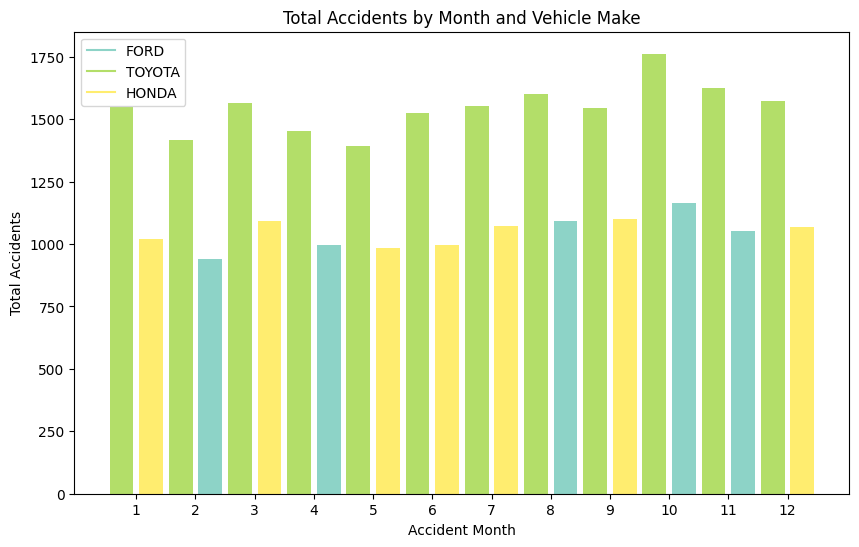

In [75]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data from the SQL query)
accident_month = np.array(rows)[:,0]
veh_make = np.array(rows)[:,1]
total_accidents = np.array(rows)[:,2]

# Get unique vehicle makes and assign colors
unique_veh_make = list(set(veh_make))
color_map = plt.cm.get_cmap('Set3')
colors = color_map(np.linspace(0, 1, len(unique_veh_make)))

# Create a bar plot with color-coded bars
plt.figure(figsize=(10, 6))
x_ticks = []
x_positions = []
legend_added = []

for i, month in enumerate(set(accident_month)):
    month_indices = [j for j in range(len(accident_month)) if accident_month[j] == month]
    x_positions.extend(month_indices)
    x_ticks.append(np.mean(month_indices))
    for j, make in enumerate(unique_veh_make):
        make_indices = [k for k in month_indices if veh_make[k] == make]
        make_accidents = [total_accidents[k] for k in make_indices]
        plt.bar(make_indices, make_accidents, color=colors[j])

        # Add legend entry only if not already added
        if make not in legend_added:
            plt.plot([], [], color=colors[j], label=make)
            legend_added.append(make)

plt.xticks(x_ticks, sorted(set(accident_month)))
plt.xlabel('Accident Month')
plt.ylabel('Total Accidents')
plt.title('Total Accidents by Month and Vehicle Make')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Connect to the Postgres container using the container name as the hostname
conn = psycopg2.connect(
    dbname="accident_analysis",
    user="postgres",
    password="password",
    host="localhost",
    port="5433"
)

# Create a cursor and execute a query
cur = conn.cursor()
cur.execute("""
WITH ranked_accidents AS (
    SELECT ai.veh_make as veh_make, 
           EXTRACT(MONTH FROM a.date_time) AS accident_month,
           COUNT(*) AS total_accidents,
           RANK() OVER (PARTITION BY EXTRACT(MONTH FROM a.date_time) ORDER BY COUNT(*) DESC) AS rank
    FROM accident_info ai
    INNER JOIN accidents a ON ai.report_id = a.report_id
    GROUP BY ai.veh_make, accident_month
)
SELECT accident_month, veh_make, total_accidents
FROM ranked_accidents
WHERE rank <= 2;
""")

# Fetch all rows from the result set
rows = cur.fetchall()
table_format(cur, rows)

# Close the cursor and the connection
cur.close()
conn.close()

In [23]:
# Connect to the Postgres container using the container name as the hostname
conn = psycopg2.connect(
    dbname="accident_analysis",
    user="postgres",
    password="password",
    host="localhost",
    port="5433"
)

# Create a cursor and execute a query
cur = conn.cursor()
cur.execute("SELECT * FROM accident_info LIMIT 5")

# Fetch all rows from the result set
rows = cur.fetchall()
table_format(cur, rows)

# Close the cursor and the connection
cur.close()
conn.close()

report_id|person_role            |veh_make|veh_model
----------------------------------------------------
171111   |PARKED VEHICLE OCCUPANT|TOYOTA  |RAV4     
192016   |PARKED VEHICLE OCCUPANT|FORD    |         
190012   |DRIVER                 |NISSAN  |ALTIMA   
191866   |DRIVER                 |FORD    |F150     
185207   |DRIVER                 |FORD    |MUSTANG  


In [22]:
# Connect to the Postgres container using the container name as the hostname
conn = psycopg2.connect(
    dbname="accident_analysis",
    user="postgres",
    password="password",
    host="localhost",
    port="5433"
)

# Create a cursor and execute a query
cur = conn.cursor()
cur.execute("SELECT * FROM accidents_on_road LIMIT 5")

# Fetch all rows from the result set
rows = cur.fetchall()
table_format(cur, rows)

# Close the cursor and the connection
cur.close()
conn.close()

report_id|objectid
------------------
171111   |8708    
192016   |2649    
192016   |8393    
192016   |8392    
192016   |72097   


In [76]:
# Connect to the Postgres container using the container name as the hostname
conn = psycopg2.connect(
    dbname="accident_analysis",
    user="postgres",
    password="password",
    host="localhost",
    port="5433"
)

# Create a cursor and execute a query
cur = conn.cursor()
cur.execute("SELECT * FROM reports LIMIT 5")

# Fetch all rows from the result set
rows = cur.fetchall()
table_format(cur, rows)

# Close the cursor and the connection
cur.close()
conn.close()

service_request_id|date_requested     |case_age_days|service_name         |service_name_detail          |status    |street_address                                         |council_district|case_origin
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
100763            |2016-08-20 14:46:00|2470         |Street Sweeping      |                             |In Process|5135 University Avenue San Diego CA 92105 United States|9               |Web        
100777            |2016-08-20 15:48:00|2470         |Sidewalk Repair Issue|SIDEWALK MINOR REHAB CONTRACT|In Process|4300-4324 37th St San Diego CA 92105 USA               |9               |Web        
100985            |2016-08-22 10:04:00|2468         |Stormwater           |DRAIN HEADWALL               |In Process|6175 NANCY RIDGE DR 92121                              |6               |Phone  